=== SETUP AND IMPORTS ===

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
import os
import json
import sys
import shutil

current_dir = os.path.abspath(os.getcwd())

REPO_ROOT  = os.path.abspath(os.path.join(current_dir, '..'))
if REPO_ROOT  not in sys.path:
    sys.path.append(REPO_ROOT )

# Project-specific modules
from dataloader.tDCBAM_trainloader import SignaturePretrainDataset, get_pretraining_transforms
from models.Triplet_Siamese_Similarity_Network import tDCBAM
from losses.triplet_loss import TripletLoss

print(f" > Repo root: {REPO_ROOT}")

/home/paweee/acads/thesis/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


 > Repo root: /home/paweee/acads/thesis


In [ ]:
# HYPERPARAMETER CONFIGURATION
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Optimized for DenseNet121 & Robustness
INPUT_SHAPE = (224, 224) 
BATCH_SIZE = 32
EPOCHS = 30
PHASE1_EPOCHS = 10  # Frozen backbone epochs (CBAM-only training)
LEARNING_RATE = 1e-4
MARGIN = 2.0

# Initialize Data Augmentation Pipeline
train_transform = get_pretraining_transforms(input_shape=INPUT_SHAPE)

print(f" > Computation Device: {DEVICE}")
print(f" > Input Shape: {INPUT_SHAPE}")
print(f" > Margin: {MARGIN}")
print(f" > Phase 1 (frozen backbone): {PHASE1_EPOCHS} epochs")
print(f" > Phase 2 (fine-tune all):   {EPOCHS - PHASE1_EPOCHS} epochs")

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

SEED = 42
seed_everything(SEED)

 > Computation Device: cuda
 > Input Shape: (224, 224)
 > Margin: 2.0
Random seed set to: 42


In [3]:
import os
import shutil
import json

# 1. Fix REPO_ROOT to point to the parent 'thesis' folder, not 'notebooks'
current_dir = os.path.abspath(os.getcwd())
if 'notebooks' in current_dir:
    REPO_ROOT = os.path.abspath(os.path.join(current_dir, '..'))
else:
    REPO_ROOT = current_dir

print(f"Project Root: {REPO_ROOT}")

# 2. Define Paths relative to the correct Root
DATA_ROOT = os.path.join(REPO_ROOT, 'data', 'bhsig260-hindi-bengali')

# Fallback: if the Kaggle folder name is different, allow direct repo/data
if not os.path.isdir(DATA_ROOT):
    alt_root = os.path.join(REPO_ROOT, 'data')
    if os.path.isdir(alt_root):
        DATA_ROOT = alt_root

working_dir = os.path.join(REPO_ROOT, 'data')
genuine_dir = os.path.join(working_dir, 'all_genuine')
forged_dir = os.path.join(working_dir, 'all_forged')
splits_dir = os.path.join(working_dir, 'splits')

# Create clean directories
for d in [genuine_dir, forged_dir, splits_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

print("Status: Consolidating BHSig dataset (Hindi + Bengali) into a unified structure...")

# Verify source data exists
if os.path.isdir(DATA_ROOT):
    # Copy genuine signatures
    hindi_gen = os.path.join(DATA_ROOT, 'BHSig160_Hindi', 'Genuine')
    bengali_gen = os.path.join(DATA_ROOT, 'BHSig100_Bengali', 'Genuine')
    
    if os.path.isdir(hindi_gen):
        os.system(f'cp -r "{hindi_gen}/"* "{genuine_dir}/" 2>/dev/null || true')
    if os.path.isdir(bengali_gen):
        os.system(f'cp -r "{bengali_gen}/"* "{genuine_dir}/" 2>/dev/null || true')
    
    # Copy forged signatures
    hindi_forg = os.path.join(DATA_ROOT, 'BHSig160_Hindi', 'Forged')
    bengali_forg = os.path.join(DATA_ROOT, 'BHSig100_Bengali', 'Forged')
    
    if os.path.isdir(hindi_forg):
        os.system(f'cp -r "{hindi_forg}/"* "{forged_dir}/" 2>/dev/null || true')
    if os.path.isdir(bengali_forg):
        os.system(f'cp -r "{bengali_forg}/"* "{forged_dir}/" 2>/dev/null || true')
    
    print(f" > Genuine files: {len(os.listdir(genuine_dir))}")
    print(f" > Forged files: {len(os.listdir(forged_dir))}")
else:
    print(f"ERROR: Data source not found at {DATA_ROOT}")

# --- FIX START: Use Absolute Path for Script ---
print(" > Generating dataset splits...")

# Construct the full path to the script
script_path = os.path.join(REPO_ROOT, 'scripts', 'restructure_bhsig.py')

# Verify the script exists before running
if not os.path.exists(script_path):
    print(f"CRITICAL ERROR: Script not found at: {script_path}")
else:
    # Run using the absolute path
    script_cmd = f"python \"{script_path}\" --base_dir \"{DATA_ROOT}\" --output_dir \"{splits_dir}\" --pretrain_users 150"
    exit_code = os.system(script_cmd)
    
    if exit_code != 0:
        print(f"Error: Script failed with exit code {exit_code}")

# Load the identified background users
background_users_path = os.path.join(splits_dir, 'bhsig_background_users.json')
if os.path.exists(background_users_path):
    with open(background_users_path, 'r') as f:
        background_users = json.load(f)
    print(f"Success: Loaded {len(background_users)} users for the Pre-training phase.")
else:
    print("Error: Background users file not found.")

Project Root: /home/paweee/acads/thesis
Status: Consolidating BHSig dataset (Hindi + Bengali) into a unified structure...
 > Genuine files: 6240
 > Forged files: 7800
 > Generating dataset splits...
[Info] Scanning data structure at: /home/paweee/acads/thesis/data
[Info] Found 30720 image files. Parsing metadata...
[Info] Successfully validated 260 users with complete data.
[Info] Split Statistics:
   - Background Users (Pre-training): 150
   - Evaluation Users (Meta-learning): 110
[Success] Saved pre-training split to: /home/paweee/acads/thesis/data/splits/bhsig_background_users.json
   > Generated Fold 0: 88 Train / 22 Val users.
   > Generated Fold 1: 88 Train / 22 Val users.
   > Generated Fold 2: 88 Train / 22 Val users.
   > Generated Fold 3: 88 Train / 22 Val users.
   > Generated Fold 4: 88 Train / 22 Val users.
Success: Loaded 150 users for the Pre-training phase.


=== DATASET AND DATALOADER INITIALIZATION ===

In [ ]:
# Initialize the Dataset using the consolidated directories
train_dataset = SignaturePretrainDataset(
    org_dir=genuine_dir,
    forg_dir=forged_dir,
    transform=None, # None or train_transform
    user_list=background_users
)

# Initialize DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Shuffle is CRITICAL for SGD
    num_workers=4,          # Parallel data loading
    pin_memory=True,        # Faster transfer to GPU
    drop_last=True          # Avoid incomplete batches causing issues
)

print(f" > Dataset Prepared.")
print(f" > Total Training Triplets available per epoch: {len(train_dataset)}")
print(f" > Batch Size: {BATCH_SIZE}")

 > Dataset Prepared.
 > Total Training Triplets available per epoch: 3600
 > Batch Size: 32


=== MODEL ARCHITECTURE AND LOSS FUNCTION ===

In [ ]:
# 1. Initialize Model
model = tDCBAM(backbone_name='densenet121', output_dim=1024, pretrained=True).to(DEVICE)
fe = model.feature_extractor  # shorthand

# 2. Loss
criterion = TripletLoss(margin=MARGIN, mode='cosine')

# ──────────────────────────────────────────────
# PHASE 1: Freeze DenseNet backbone, train only CBAM + fc
# ──────────────────────────────────────────────

# Freeze pretrained DenseNet layers
for module in [fe.initial_layers, fe.block1, fe.trans1,
               fe.block2, fe.trans2, fe.block3, fe.trans3,
               fe.block4, fe.norm5]:
    for param in module.parameters():
        param.requires_grad = False

# Only CBAM blocks + fc are trainable
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'loss': [], 'phase': []}
CHECKPOINT_DIR = os.path.join(REPO_ROOT, 'checkpoints', 'pretraining')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
best_loss = float('inf')
best_ckpt_path = os.path.join(CHECKPOINT_DIR, "tDCBAM_pretrain_best.pth")

trainable_p1 = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params  = sum(p.numel() for p in model.parameters())
print(f"Phase 1: Training {trainable_p1:,} / {total_params:,} params (CBAM + fc only)")
print(f"Starting Phase 1 for {PHASE1_EPOCHS} epochs...\n")

for epoch in range(PHASE1_EPOCHS):
    model.train()
    running_loss = 0.0
    train_dataset.on_epoch_end()
    pbar = tqdm(train_loader, desc=f"[P1] Epoch {epoch+1}/{PHASE1_EPOCHS}", leave=False)

    for batch_idx, (anchor, positive, negative, _) in enumerate(pbar):
        anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
        optimizer.zero_grad()
        anchor_emb, pos_emb, neg_emb = model(anchor, positive, negative)
        loss = criterion(anchor_emb, pos_emb, neg_emb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(train_loader)
    history['loss'].append(avg_loss)
    history['phase'].append(1)
    scheduler.step(avg_loss)
    print(f"[P1] Epoch [{epoch+1}/{PHASE1_EPOCHS}] | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'feature_extractor': fe.state_dict(),
            'loss': avg_loss,
            'phase': 1,
            'config': {
                'input_shape': INPUT_SHAPE,
                'batch_size': BATCH_SIZE,
                'learning_rate': LEARNING_RATE,
                'margin': MARGIN
            }
        }, best_ckpt_path)
        print(f"   >>> Best model saved (loss: {best_loss:.4f})")

# ──────────────────────────────────────────────
# PHASE 2: Unfreeze all, fine-tune with differential LR
# ──────────────────────────────────────────────
PHASE2_EPOCHS = EPOCHS - PHASE1_EPOCHS

# Unfreeze everything
for param in model.parameters():
    param.requires_grad = True

# Differential learning rates: backbone low, CBAM/fc higher
optimizer = torch.optim.Adam([
    {'params': fe.initial_layers.parameters(), 'lr': 1e-5},
    {'params': fe.block1.parameters(), 'lr': 1e-5},
    {'params': fe.trans1.parameters(), 'lr': 1e-5},
    {'params': fe.block2.parameters(), 'lr': 1e-5},
    {'params': fe.trans2.parameters(), 'lr': 1e-5},
    {'params': fe.block3.parameters(), 'lr': 1e-5},
    {'params': fe.trans3.parameters(), 'lr': 1e-5},
    {'params': fe.block4.parameters(), 'lr': 1e-5},
    {'params': fe.norm5.parameters(),  'lr': 1e-5},
    {'params': fe.cbam1.parameters(),  'lr': 1e-4},
    {'params': fe.cbam2.parameters(),  'lr': 1e-4},
    {'params': fe.cbam3.parameters(),  'lr': 1e-4},
    {'params': fe.cbam4.parameters(),  'lr': 1e-4},
    {'params': fe.fc.parameters(),     'lr': 1e-4},
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"\nPhase 2: Fine-tuning ALL {total_params:,} params with differential LR")
print(f"  Backbone LR: 1e-5 | CBAM/fc LR: 1e-4")
print(f"Starting Phase 2 for {PHASE2_EPOCHS} epochs...\n")

for epoch in range(PHASE2_EPOCHS):
    model.train()
    running_loss = 0.0
    train_dataset.on_epoch_end()
    pbar = tqdm(train_loader, desc=f"[P2] Epoch {epoch+1}/{PHASE2_EPOCHS}", leave=False)

    for batch_idx, (anchor, positive, negative, _) in enumerate(pbar):
        anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
        optimizer.zero_grad()
        anchor_emb, pos_emb, neg_emb = model(anchor, positive, negative)
        loss = criterion(anchor_emb, pos_emb, neg_emb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(train_loader)
    history['loss'].append(avg_loss)
    history['phase'].append(2)
    scheduler.step(avg_loss)
    global_epoch = PHASE1_EPOCHS + epoch + 1
    print(f"[P2] Epoch [{epoch+1}/{PHASE2_EPOCHS}] (Global {global_epoch}/{EPOCHS}) | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': global_epoch,
            'model_state_dict': model.state_dict(),
            'feature_extractor': fe.state_dict(),
            'loss': avg_loss,
            'phase': 2,
            'config': {
                'input_shape': INPUT_SHAPE,
                'batch_size': BATCH_SIZE,
                'learning_rate': LEARNING_RATE,
                'margin': MARGIN
            }
        }, best_ckpt_path)
        print(f"   >>> Best model saved (loss: {best_loss:.4f})")

# Save Final Feature Extractor Weights
final_weights_path = os.path.join(REPO_ROOT, "background_pretrain.pth")
torch.save(fe.state_dict(), final_weights_path)
print(f"\nTraining Complete. Final weights saved to: {final_weights_path}")
print(f"Best checkpoint saved to: {best_ckpt_path}")

Starting Training for 30 epochs...
Checkpoints will be saved to: /home/paweee/acads/thesis/checkpoints/pretraining


Epoch 1/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [1/30] | Triplet Loss: 1.5586 | LR: 1.00e-04


Epoch 2/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [2/30] | Triplet Loss: 1.0702 | LR: 1.00e-04


Epoch 3/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [3/30] | Triplet Loss: 0.9075 | LR: 1.00e-04


Epoch 4/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [4/30] | Triplet Loss: 0.8431 | LR: 1.00e-04


Epoch 5/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [5/30] | Triplet Loss: 0.7810 | LR: 1.00e-04
   >>> Checkpoint saved: tDCBAM_pretrain_epoch_5.pth


Epoch 6/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [6/30] | Triplet Loss: 0.6924 | LR: 1.00e-04


Epoch 7/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [7/30] | Triplet Loss: 0.6283 | LR: 1.00e-04


Epoch 8/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [8/30] | Triplet Loss: 0.6709 | LR: 1.00e-04


Epoch 9/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [9/30] | Triplet Loss: 0.6485 | LR: 1.00e-04


Epoch 10/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [10/30] | Triplet Loss: 0.6044 | LR: 1.00e-04
   >>> Checkpoint saved: tDCBAM_pretrain_epoch_10.pth


Epoch 11/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [11/30] | Triplet Loss: 0.5984 | LR: 1.00e-04


Epoch 12/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [12/30] | Triplet Loss: 0.6317 | LR: 1.00e-04


Epoch 13/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [13/30] | Triplet Loss: 0.5317 | LR: 1.00e-04


Epoch 14/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [14/30] | Triplet Loss: 0.4792 | LR: 1.00e-04


Epoch 15/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [15/30] | Triplet Loss: 0.4227 | LR: 1.00e-04
   >>> Checkpoint saved: tDCBAM_pretrain_epoch_15.pth


Epoch 16/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [16/30] | Triplet Loss: 0.4138 | LR: 1.00e-04


Epoch 17/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [17/30] | Triplet Loss: 0.3743 | LR: 1.00e-04


Epoch 18/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [18/30] | Triplet Loss: 0.2332 | LR: 1.00e-04


Epoch 19/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [19/30] | Triplet Loss: 0.2726 | LR: 1.00e-04


Epoch 20/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [20/30] | Triplet Loss: 0.1379 | LR: 1.00e-04
   >>> Checkpoint saved: tDCBAM_pretrain_epoch_20.pth


Epoch 21/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [21/30] | Triplet Loss: 0.1575 | LR: 1.00e-04


Epoch 22/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [22/30] | Triplet Loss: 0.0797 | LR: 1.00e-04


Epoch 23/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [23/30] | Triplet Loss: 0.0143 | LR: 1.00e-04


Epoch 24/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [24/30] | Triplet Loss: 0.4011 | LR: 1.00e-04


Epoch 25/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [25/30] | Triplet Loss: 1.4280 | LR: 1.00e-04
   >>> Checkpoint saved: tDCBAM_pretrain_epoch_25.pth


Epoch 26/30:   0%|          | 0/112 [00:00<?, ?it/s]

KeyboardInterrupt: 

=== TRAINING VISUALIZATION ===

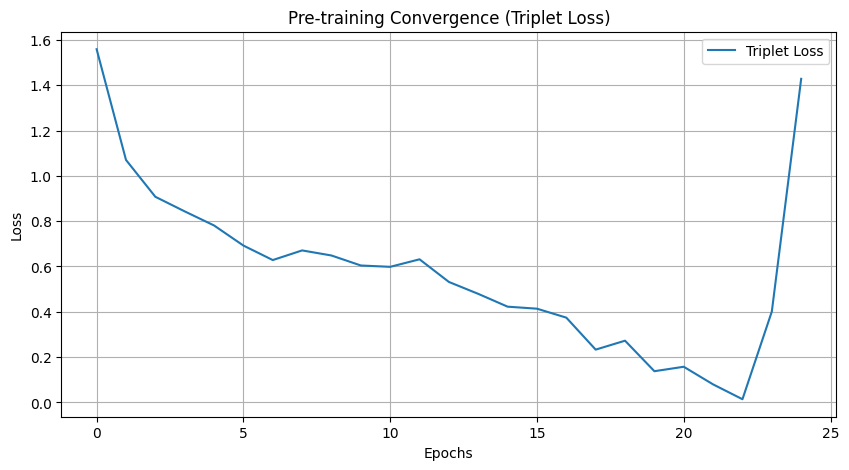

In [ ]:
# Plot Training Loss with Phase Boundary
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Triplet Loss', marker='o', markersize=3)
plt.axvline(x=PHASE1_EPOCHS - 0.5, color='red', linestyle='--', alpha=0.7, label='Phase 1 → 2 transition')
plt.fill_betweenx([min(history['loss'])*0.95, max(history['loss'])*1.05],
                   0, PHASE1_EPOCHS - 0.5, alpha=0.08, color='blue', label='Phase 1 (frozen backbone)')
plt.fill_betweenx([min(history['loss'])*0.95, max(history['loss'])*1.05],
                   PHASE1_EPOCHS - 0.5, EPOCHS, alpha=0.08, color='green', label='Phase 2 (fine-tune all)')
plt.title('Pre-training Convergence (Two-Phase Freeze/Train)')
plt.xlabel('Epochs')
plt.ylabel('Triplet Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()